In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.',
                                  cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 2s 0us/step


In [ ]:
os.listdir(dataset_dir)

['imdb.vocab', 'README', 'test', 'imdbEr.txt', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'pos',
 'unsupBow.feat']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
print("label 0 corresponds to", raw_train_ds.class_names[0])
print("label 1 corresponds to", raw_train_ds.class_names[1])

label 0 corresponds to neg
label 1 corresponds to pos


In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br/>',' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]'%re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length = sequence_length
)

In [ ]:
# Make a text-only dataset(without labels), then call adapt
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)


In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorize review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorize review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1223, 1022,   28,  262,  101,    4,    1, 1510,
        7037,  247,   33, 1482,    1, 1654,    4, 

In [ ]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  naked
 313 --->  night
Vocabulary size: 10000


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
      layers.Embedding(max_features + 1, embedding_dim),
      layers.Dropout(0.2),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.2),
      layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = losses.BinaryCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6642 - binary_accuracy: 0.6876 - val_loss: 0.6160 - val_binary_accuracy: 0.7728
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5514 - binary_accuracy: 0.7995 - val_loss: 0.5014 - val_binary_accuracy: 0.8186
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4488 - binary_accuracy: 0.8426 - val_loss: 0.4239 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3816 - binary_accuracy: 0.8637 - val_loss: 0.3777 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3396 - binary_accuracy: 0.8762 - val_loss: 0.3486 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3084 - binary_accuracy: 0.8871 - val_loss: 0.3298 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3130 - binary_accuracy: 0.8714
Loss:  0.3130398690700531
Accuracy:  0.871399998664856


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

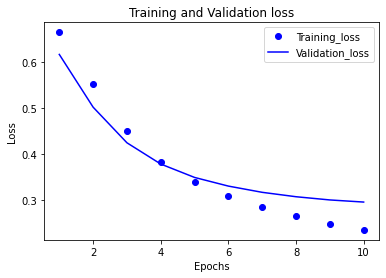

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training_loss")

plt.plot(epochs, val_loss, 'b', label = "Validation_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

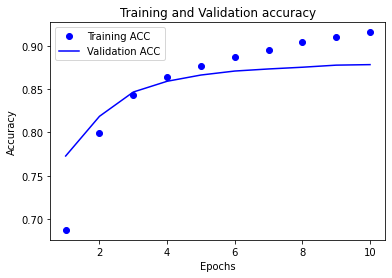

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training ACC')
plt.plot(epochs,val_acc,'b',label='Validation ACC')
plt.title("Training and Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
      vectorize_layer,
      model,
      layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics = ['accuracy']
)
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3130 - accuracy: 0.8714
0.871399998664856


In [ ]:
examples = [
            "The movie was amazing!",
            "The movie was soso.",
            "The movie sucks..."
]

export_model.predict(examples)

array([[0.66495025],
       [0.5138194 ],
       [0.4602736 ]], dtype=float32)